In [72]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense

In [73]:
# Custom rc definitions
rc = {
        'axes.spines.right': True,
        'axes.spines.top': True,
        'font.family': ['sans-serif'],
        'font.sans-serif':
        # 'Arial',
        'DejaVu Sans',
        # 'Liberation Sans',
        # 'Bitstream Vera Sans',
        # 'sans-serif',
        "xtick.bottom":True,
        'axes.edgecolor': 'indigo',
        'xtick.color': 'black',
        'figure.facecolor': "snow",
        'grid.color': 'grey',
        
}


# font definitions
font_label = {'family': 'serif',
        'color':  'darkred',
        'weight': 'semibold',
        'size': 16,
        }

font_title = {'family': 'serif',
        'color':  'black',
        'weight': 'semibold',
        'size': 16,
        }

font_fig = {'family': 'sans',
        'color':  'chocolate',
        # 'weight': 'bold', # doesn't apply to it. Must be specified independently
        # 'fontsize': 30, # doesn't apply to it. Must be specified independently
        }

In [74]:
import os

# desktop
desktop_path = os.path.expanduser("~/Desktop")

# data file path
machine = os.path.join(desktop_path,"machine")
data_science = os.path.join(machine,"data_science")
rice_type_classification = os.path.join(data_science,"rice-type-classification")
data_file = os.path.join(rice_type_classification,"my_data/clusters.csv")

In [75]:
data = pd.read_csv(data_file)

In [76]:
data = pd.get_dummies(data,columns=['class'],drop_first=True)
data.head()

,area,majoraxislength,minoraxislength,eccentricity,convexarea,equivdiameter,extent,perimeter,roundness,aspectration,clusters,class_jasmine
0,6374,129.577,63.762,0.871,6476,90.087,0.662,314.656,0.809,2.032,3,1
1,6946,136.304,65.738,0.876,7115,94.042,0.594,338.782,0.761,2.073,1,1
2,5786,125.555,59.626,0.880,5945,85.831,0.623,307.304,0.770,2.106,3,1
3,5896,127.014,59.843,0.882,6092,86.643,0.610,309.264,0.775,2.122,3,1
4,6082,129.098,60.416,0.884,6204,87.999,0.661,308.106,0.805,2.137,3,1


In [77]:
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

In [78]:
X = data.drop(columns=["extent"])
y = data.extent

In [79]:
to_transform = ['area','majoraxislength','minoraxislength',
                'convexarea','equivdiameter','perimeter']

indexes = [ X.columns.tolist().index(value) for value in to_transform]
indexes

[0, 1, 2, 4, 5, 6]

In [80]:
# Scaler
scaler = StandardScaler()

# Column transformer
ct1 = ColumnTransformer([
    ('scale',scaler,indexes)],
    remainder='passthrough')

In [81]:
my_pipe = Pipeline([
    # ("poly",PolynomialFeatures(degree=2,include_bias=False)),
    ("ct",ct1)
])

In [82]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=.20)

In [83]:
X_train_preprocessed = my_pipe.fit_transform(X_train)
X_test_preprocessed = my_pipe.transform(X_test)

In [84]:
import pickle

with open('../pipeline/pipeline_regressor.pkl','wb') as filer:
    pickle.dump(my_pipe,filer)

In [85]:
from tensorflow.keras.layers import Input,Add
from tensorflow.keras.models import Model

In [86]:
def residual_block(x):
    identity = x
    x = Dense(64,activation='relu',name="residual_block_layer_1")(x) # 64
    x = Dense(64,activation='relu',name="residual_block_layer_2")(x) # 64
    x = Add()([identity,x] )# 64 + 64 = 128

    return x

In [87]:
def custom_model(input_shape):
    inputs = Input(shape=(input_shape,),name='input_layer')
    x = Dense(64,activation='relu',name="layer1")(inputs)
    x = residual_block(x) # 128
    x = Dense(32,activation="relu",name="layer2")(x) 
    x = Dense(16,activation="relu",name="layer3")(x)
    x = Dropout(.7)(x)
    output_layer= Dense(1,activation=None,name="output")(x)
    model = Model(inputs=inputs,outputs=output_layer)

    return model


In [88]:
X_train_preprocessed.shape

(14117, 11)

In [89]:
X_train_preprocessed[:1]

array([[-1.28272086, -0.62321823, -1.36230057, -1.3339193 , -1.33254602,
        -1.2864855 ,  0.949     ,  0.648     ,  3.166     ,  3.        ,
         1.        ]])

In [90]:
model = custom_model(X_test_preprocessed.shape[1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 11)]         0           []                               
                                                                                                  
 layer1 (Dense)                 (None, 64)           768         ['input_layer[0][0]']            
                                                                                                  
 residual_block_layer_1 (Dense)  (None, 64)          4160        ['layer1[0][0]']                 
                                                                                                  
 residual_block_layer_2 (Dense)  (None, 64)          4160        ['residual_block_layer_1[0][0]'] 
                                                                                              

In [91]:
# Define the custom callback
class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MyCustomCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            val_loss = logs.get('val_loss') 
            loss = logs.get('loss')
            val_acc = logs.get('val_acc')
            acc = logs.get('acc')
            val_root_mean_squared_error = logs.get('val_root_mean_squared_error')
            root_mean_squared_error = logs.get('root_mean_squared_error')
            if (val_root_mean_squared_error < 0.01 ):
                print(f"\nValidation root_mean_squared_error < 0.01\nStopping training.\n")
                self.model.stop_training = True

my_callback = MyCustomCallback()

In [92]:
import datetime
class TimeCallback(tf.keras.callbacks.Callback):

    def on_epoch_begin(self,epoch, logs=None):
        print('Epoch: {}, begins at {}\n'.format(epoch, datetime.datetime.now().time()))

    def on_epoch_end(self,epoch, logs=None):
        print('Epoch: {}, ends at {}\n'.format(epoch, datetime.datetime.now().time()))

my_timer = TimeCallback()

In [101]:
# Learning Rate Schedulers
peak_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode= 'min',
    min_lr=0.00001
)

# Learning rate scheduler
def scheduler(epoch,lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

my_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
# optimizer
optimise = tf.keras.optimizers.Adam(learning_rate=0.01)
# losses
my_loss = tf.keras.losses.mean_squared_error

# metrics
my_rmse = tf.keras.metrics.RootMeanSquaredError()

In [94]:
model.compile(optimizer=optimise,loss=my_loss,
            metrics=["acc",my_rmse])

In [95]:
tf.keras.backend.clear_session()
model_history = model.fit(X_train_preprocessed,y_train,
                        epochs=20,batch_size=16,validation_split=.20,
                        # steps_per_epoch=5,
                        callbacks=[my_callback,my_scheduler,
                                    peak_callback,my_timer])

Epoch: 0, begins at 17:04:13.434843

Epoch 1/20
699/706 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.0000e+00 - root_mean_squared_error: 0.1448Epoch: 0, ends at 17:04:18.540076

706/706 [==============================] - 5s 5ms/step - loss: 0.0209 - acc: 0.0000e+00 - root_mean_squared_error: 0.1445 - val_loss: 0.0098 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 0.0988 - lr: 0.0100
Epoch: 1, begins at 17:04:18.545091

Epoch 2/20
695/706 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.0000e+00 - root_mean_squared_error: 0.1028Epoch: 1, ends at 17:04:21.544738

706/706 [==============================] - 3s 4ms/step - loss: 0.0106 - acc: 0.0000e+00 - root_mean_squared_error: 0.1028 - val_loss: 0.0098 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 0.0992 - lr: 0.0100
Epoch: 2, begins at 17:04:21.549833

Epoch 3/20
698/706 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.0000e+00 - root_mean_squared_error: 0.1028Epoch: 

In [96]:
score = model.evaluate(X_test_preprocessed,y_test,verbose=1)

111/111 [==============================] - 0s 2ms/step - loss: 0.0098 - acc: 0.0000e+00 - root_mean_squared_error: 0.0989


In [98]:
print(f'Standard Deviation of Extent: {np.around(data.extent.std(),3)}') # std of Extent
# RMSE score is lower than std of Extent; Algorithm does well?

Standard Deviation of Extent: 0.104


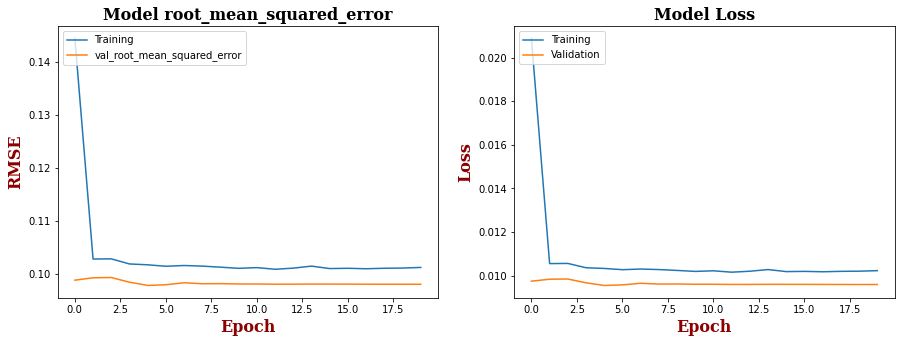

In [107]:
# Model Performance Charts
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Plot accuracy
ax[0].plot(model_history.history['root_mean_squared_error'])
ax[0].plot(model_history.history['val_root_mean_squared_error'])
ax[0].set_title('Model root_mean_squared_error',fontdict=font_title)
ax[0].set_ylabel('RMSE',fontdict=font_label)
ax[0].set_xlabel('Epoch',fontdict=font_label)
ax[0].legend(['Training', 'val_root_mean_squared_error'], loc='upper left')

# Plot loss
ax[1].plot(model_history.history['loss'])
ax[1].plot(model_history.history['val_loss'])
ax[1].set_title('Model Loss',fontdict=font_title)
ax[1].set_ylabel('Loss',fontdict=font_label)
ax[1].set_xlabel('Epoch',fontdict=font_label)
ax[1].legend(['Training', 'Validation'], loc='upper left')

# Show the plots
plt.show()


In [118]:
y_pred_test = model.predict(X_test_preprocessed) 
y_pred_test
predictions = [predictions for sublist in y_pred_test.tolist() for predictions in sublist]
# print(predictions)

111/111 [==============================] - 0s 2ms/step


In [119]:
percent_error = 100* ((predictions-y_test)/y_test)
data = {
    'predicted_extent':predictions,
    'actual_extent':y_test,
    "percentage_error":percent_error
}
predictions_frame = pd.DataFrame(data)
predictions_frame.to_csv("my_data/reg_deep_predictions/reg_deep_predictions.csv"
                    ,index=True)
predictions_frame.head(5)

,predicted_extent,actual_extent,percentage_error
5277,0.601485,0.651,-7.605934
8354,0.592849,0.469,26.407065
2718,0.603835,0.547,10.390374
7895,0.592611,0.479,23.718288
4205,0.598503,0.667,-10.269363


In [129]:
cond = (predictions_frame.percentage_error == 0)
predictions_frame.loc[cond,:].value_counts().sum()

0

Text(0, 0.5, 'Actual Extent')

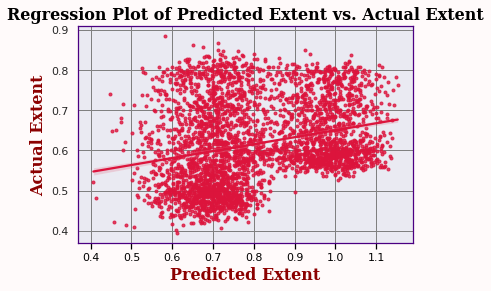

In [115]:
# Regression plot
sns.set_theme(style='darkgrid',rc=rc)
sns.regplot(data=predictions_frame,
        x='predicted_extent',
        y='actual_extent',
        fit_reg=True,
        color='crimson',
        marker='.')
plt.title('Regression Plot of Predicted Extent vs. Actual Extent',fontdict=font_title)
plt.xlabel('Predicted Extent',fontdict=font_label)
plt.ylabel('Actual Extent',fontdict=font_label)

In [116]:
# model = os.path
model_path = "model"
model.save(f"../{model_path}/regressor")

INFO:tensorflow:Assets written to: model/regressor\assets
